In [1]:
from jetutils.definitions import *
from jetutils.data import *
from jetutils.jet_finding import *
from jetutils.anyspell import *
from jetutils.plots import *
from jetutils.geospatial import *

%load_ext IPython.extensions.autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["RUST_BACKTRACE"] = "full"

Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  4
Guessed MEMORY_LIMIT :  153600


IPython could not be loaded!


## wb?

In [ ]:
import wavebreaking as wb

def compute_zeta(ds):
    lon, lat = ds["lon"].values, ds["lat"].values
    xlon, ylat = np.meshgrid(lon, lat)

    _, dlonx = np.gradient(xlon)
    dlaty, _ = np.gradient(ylat)


    dx = RADIUS * degcos(ylat) * dlonx * np.pi / 180
    dy = RADIUS * dlaty * np.pi / 180

    f = 2 * OMEGA * degsin(ylat)

    u = ds["u"].assign_coords(lati=("lat", np.arange(len(ds.lat)))).chunk({"lat": -1, "lon": -1})
    dudy = u.differentiate("lat") / dy[None, :, :, None]
    v = ds["v"].assign_coords(loni=("lat", np.arange(len(ds.lat)))).chunk({"lat": -1, "lon": -1})
    dvdx = v.differentiate("lon") / dx[None, :, :, None]

    zeta = dudy - dvdx + f[None, :, :, None]

    zeta = compute(zeta, progress_flag=False)
    return zeta 


def compute_mflux(ds):
    ds = ds.assign_coords(lat=0.7 + np.arange(len(ds.lat), dtype=np.float128) * 0.94)
    out = []
    for ilev in np.arange(len(ds["lev"])):
        ds_ = ds.isel(lev=ilev)
        mflux = wb.calculate_momentum_flux(u=ds_["u"], v=ds_["v"])
        out.append(mflux)
    out = xr.concat(out, dim="lev")
    out = compute(out, progress_flag=False)
    return out


for run in ["ctrl", "dobl"]:
    basepath_i = Path(DATADIR, f"Henrik_data/{run}/high_wind/6H")
    basepath_zeta = Path(DATADIR, f"Henrik_data/{run}/zeta/6H")
    basepath_zeta.mkdir(parents=True, exist_ok=True)
    basepath_mflux = Path(DATADIR, f"Henrik_data/{run}/mflux/6H")
    basepath_mflux.mkdir(parents=True, exist_ok=True)

    glob = basepath_i.glob("????.nc")

    for f in glob:
        oname = f.name
        ofile = basepath_zeta.joinpath(oname)
        if not ofile.is_file():
            ds = xr.open_dataset(f)
            ds = ds[["u", "v"]]
            zeta = compute_zeta(ds)
            zeta.to_netcdf(ofile)
            print("zeta", oname, run)
        ofile = basepath_mflux.joinpath(oname)
        if not ofile.is_file():
            ds = xr.open_dataset(f)
            ds = ds[["u", "v"]]
            mflux = compute_zeta(ds)
            mflux.to_netcdf(ofile)
            print("mflux", oname, run)


In [ ]:
import wavebreaking as wb

for run in ["ctrl", "dobl"]:
    basepath_zeta = Path(DATADIR, f"Henrik_data/{run}/zeta/6H")
    basepath_mflux = Path(DATADIR, f"Henrik_data/{run}/mflux/6H")
    for year in range(1969, 2021):
        zeta = xr.open_dataarray(basepath_zeta.joinpath(f"{year}.nc")).interp(lat=np.arange(1, 91)).rename("zeta")
        mflux = xr.open_dataarray(basepath_mflux.joinpath(f"{year}.nc")).interp(lat=np.arange(1, 91)).rename("mflux")
        for ilev in range(len(zeta.lev)):
            zeta_ = wb.calculate_smoothed_field(
                data=zeta.isel(lev=ilev),
                passes=5,
                weights=np.array([[0, 1, 0], [1, 2, 1], [0, 1, 0]]),
                mode="wrap"
            )
            out = wb.calculate_streamers(
                data=zeta_ * 1e5,
                contour_levels=[-7.5, 7.5],
                geo_dis=800, # optional
                cont_dis=1200, # optional
                intensity=mflux.isel(lev=ilev), # optional
                periodic_add=120
            )
        break
    break

In [221]:
out

,date,level,com,mean_var,intensity,event_area,geometry
0,1969-01-01 00:00:00,7.5,"(-83.75, 33.0)",4.88,0.0,6911685.49,"POLYGON ((-127.5 28, -126.25 29, -125 29, -123..."
1,1969-01-01 00:00:00,7.5,"(-96.25, 24.0)",8.79,0.0,4622068.77,"POLYGON ((-66.25 30, -67.5 30, -68.75 29, -70 ..."
2,1969-01-01 00:00:00,7.5,"(21.25, 28.0)",6.72,0.0,1955520.05,"POLYGON ((3.75 27, 5 27, 6.25 28, 7.5 29, 8.75..."
3,1969-01-01 00:00:00,7.5,"(10.0, 19.0)",8.24,0.0,558198.10,"POLYGON ((11.25 24, 10 23, 8.75 22, 7.5 21, 7...."
4,1969-01-01 00:00:00,7.5,"(65.0, 20.0)",8.52,0.0,452363.02,"POLYGON ((62.5 18, 63.75 18, 65 18, 66.25 19, ..."
...,...,...,...,...,...,...,...
19542,1969-12-31 18:00:00,7.5,"(-71.25, 22.0)",7.23,0.0,332640.87,"POLYGON ((-75 21, -73.75 22, -72.5 23, -71.25 ..."
19543,1969-12-31 18:00:00,7.5,"(6.25, 45.0)",6.21,0.0,759964.23,"POLYGON ((3.75 41, 3.75 42, 2.5 43, 2.5 44, 2...."
19544,1969-12-31 18:00:00,7.5,"(111.25, 42.0)",9.42,0.0,2448507.14,"POLYGON ((93.75 36, 95 36, 96.25 37, 97.5 37, ..."
19545,1969-12-31 18:00:00,7.5,"(146.25, 41.0)",5.51,0.0,14343395.19,"MULTIPOLYGON (((111.25 40, 112.5 41, 113.75 41..."


## base

In [2]:
run = "ctrl"

dh = DataHandler.from_specs("Henrik_data", run, ("high_wind", ["u", "v", "s", "theta"]), "6H", minlon=-80, maxlon=40, minlat=15, maxlat=80, levels=20000)
exp = JetFindingExperiment(dh)
basepath_ctrl = exp.path

all_jets_one_df = exp.find_jets(force=False, n_coarsen=1, smooth_s=5, alignment_thresh=0.55, base_s_thresh=0.55, int_thresh_factor=0.2, hole_size=5)
# theta300 = open_da("Henrik_data", run, ("high_wind", ["s", "theta"]), "6H", minlon=-80, maxlon=40, minlat=15, maxlat=80, levels=30000).rename({"s": "s300", "theta": "theta300"})
# all_jets_one_df = add_feature_for_cat(all_jets_one_df, "s300", theta300, ofile_ajdf=exp.path.joinpath("all_jets_one_df.parquet"), force=False)
# all_jets_one_df = add_feature_for_cat(all_jets_one_df, "theta300", theta300, ofile_ajdf=exp.path.joinpath("all_jets_one_df.parquet"), force=False)
# all_jets_one_df = exp.categorize_jets(None, ["s300", "theta300"], force=False, n_init=15, init_params="k-means++", mode="month").cast({"time": pl.Datetime("ms")})
props_uncat = exp.props_as_df(categorize=False).cast({"time": pl.Datetime("ms")})

all_times = props_uncat["time"].unique().sort().to_frame()
summer_filter = (
    all_times
    .filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
    .filter(pl.col("time").dt.ordinal_day() > 166)
)
summer = summer_filter["time"]
summer_daily = summer.filter(summer.dt.hour() == 0)
big_summer = all_times.filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
big_summer_daily = big_summer.filter(big_summer["time"].dt.hour() == 0)

phat_filter = (pl.col("is_polar") < 0.5) | ((pl.col("is_polar") > 0.5) & (pl.col("int") > 1.e8))
phat_jets = all_jets_one_df.filter((pl.col("is_polar").mean().over(["time", "jet ID"]) < 0.5) | ((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5) & (pl.col("int").mode().first().over(["time", "jet ID"]) > 1.e8)))

jets_ctrl = phat_jets.with_columns(**{"jet ID": (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.UInt32())})
phat_props = props_uncat.filter(phat_filter)
phat_props_catd = average_jet_categories(phat_props, polar_cutoff=0.5)
phat_props_catd = phat_props_catd.join(phat_props_catd.rolling("time", period="2d", group_by="jet").agg(**{f"{col}_var": pl.col(col).var() for col in ["mean_lon", "mean_lat", "mean_s", "s_star"]}), on=["time", "jet"])
props_ctrl = phat_props_catd.clone()
props_summer_ctrl = summer_filter.join(props_ctrl, on="time")

cross_catd_ofile = basepath_ctrl.joinpath("cross_catd.parquet")
if cross_catd_ofile.is_file():
    cross_catd = pl.read_parquet(cross_catd_ofile)
else:
    cross_catd = track_jets(jets_ctrl)
    cross_catd.write_parquet(cross_catd_ofile)

pers = pers_from_cross_catd(cross_catd)
spells_ctrl = spells_from_cross_catd_simple(cross_catd, season=summer, q_STJ=0.795, q_EDJ=0.821, minlen=datetime.timedelta(days=5), smooth=datetime.timedelta(hours=24), fill_holes=datetime.timedelta(hours=18))

for jet in ["STJ", "EDJ"]:
    print(jet, spells_ctrl[jet]["spell"].n_unique())
    
daily_spells_ctrl = {a: make_daily(b, "spell", ["len", "spell_of"]) for a, b in spells_ctrl.items()}
pers = pers.with_columns(jet=pl.when(pl.col("jet ID") == 0).then(pl.lit("STJ")).otherwise(pl.lit("EDJ")))[["time", "jet", "pers"]]
props_ctrl = props_ctrl.join(pers[["time", "jet", "pers"]], on=["time", "jet"])

props_ctrl_summer = summer_filter.join(props_ctrl, on="time")

STJ 30
EDJ 30


In [3]:
run = "dobl"

dh = DataHandler.from_specs("Henrik_data", run, ("high_wind", ["u", "v", "s", "theta"]), "6H", minlon=-80, maxlon=40, minlat=15, maxlat=80, levels=20000)
exp = JetFindingExperiment(dh)
basepath_dobl = exp.path

all_jets_one_df = exp.find_jets(force=False, n_coarsen=1, smooth_s=5, alignment_thresh=0.55, base_s_thresh=0.55, int_thresh_factor=0.2, hole_size=5)
# theta300 = open_da("Henrik_data", run, ("high_wind", ["s", "theta"]), "6H", minlon=-80, maxlon=40, minlat=15, maxlat=80, levels=30000).rename({"s": "s300", "theta": "theta300"})
# all_jets_one_df = add_feature_for_cat(all_jets_one_df, "s300", theta300, ofile_ajdf=exp.path.joinpath("all_jets_one_df.parquet"), force=False)
# all_jets_one_df = add_feature_for_cat(all_jets_one_df, "theta300", theta300, ofile_ajdf=exp.path.joinpath("all_jets_one_df.parquet"), force=False)
# all_jets_one_df = exp.categorize_jets(None, ["s300", "theta300"], force=False, n_init=15, init_params="k-means++", mode="month").cast({"time": pl.Datetime("ms")})
props_uncat = exp.props_as_df(categorize=False).cast({"time": pl.Datetime("ms")})

all_times = props_uncat["time"].unique().sort().to_frame()
summer_filter = (
    all_times
    .filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
    .filter(pl.col("time").dt.ordinal_day() > 166)
)
summer = summer_filter["time"]
summer_daily = summer.filter(summer.dt.hour() == 0)
big_summer = all_times.filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
big_summer_daily = big_summer.filter(big_summer["time"].dt.hour() == 0)

phat_filter = (pl.col("is_polar") < 0.5) | ((pl.col("is_polar") > 0.5) & (pl.col("int") > 1.e8))
phat_jets = all_jets_one_df.filter((pl.col("is_polar").mean().over(["time", "jet ID"]) < 0.5) | ((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5) & (pl.col("int").mode().first().over(["time", "jet ID"]) > 1.e8)))

jets_dobl = phat_jets.with_columns(**{"jet ID": (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.UInt32())})
phat_props = props_uncat.filter(phat_filter)
phat_props_catd = average_jet_categories(phat_props, polar_cutoff=0.5)
phat_props_catd = phat_props_catd.join(phat_props_catd.rolling("time", period="2d", group_by="jet").agg(**{f"{col}_var": pl.col(col).var() for col in ["mean_lon", "mean_lat", "mean_s", "s_star"]}), on=["time", "jet"])
props_dobl = phat_props_catd.clone()
props_summer_dobl = summer_filter.join(props_dobl, on="time")

cross_catd_ofile = basepath_dobl.joinpath("cross_catd.parquet")
if cross_catd_ofile.is_file():
    cross_catd = pl.read_parquet(cross_catd_ofile)
else:
    cross_catd = track_jets(jets_dobl)
    cross_catd.write_parquet(cross_catd_ofile)

pers = pers_from_cross_catd(cross_catd)
spells_dobl = spells_from_cross_catd_simple(cross_catd, season=summer, q_STJ=0.804, q_EDJ=0.78, minlen=datetime.timedelta(days=5), smooth=datetime.timedelta(hours=24), fill_holes=datetime.timedelta(hours=18))

for jet in ["STJ", "EDJ"]:
    print(jet, spells_dobl[jet]["spell"].n_unique())
    
daily_spells_dobl = {a: make_daily(b, "spell", ["len", "spell_of"]) for a, b in spells_dobl.items()}
pers = pers.with_columns(jet=pl.when(pl.col("jet ID") == 0).then(pl.lit("STJ")).otherwise(pl.lit("EDJ")))[["time", "jet", "pers"]]
props_dobl = props_dobl.join(pers[["time", "jet", "pers"]], on=["time", "jet"])

props_dobl_summer = summer_filter.join(props_dobl, on="time")

STJ 30
EDJ 30


In [7]:
long_names = {
    "theta": r"$\theta$",
    "z": "500 hPa $z$",
    "t_low": "1000 hPa T.",
    "DTCOND": "Diabatic T tendencies",
    "PTTEND": r"T tendencies due to physics",
}

factors = {
    "theta": 1,
    "z": 1,
    "t_low": 1,
    "DTCOND": 86400,
    "PTTEND": 86400,
}

units = {
    "theta": "K",
    "z": "m",
    "t_low": "K",
    "DTCOND": r"K/d",
    "PTTEND": r"K/d",
}

to_plot = {
    "theta:clim": [6, colormaps.amp, [315, 340]],
    "theta:anom": [8, colormaps.BlWhRe, [-3, 3]],
    "theta:clim_grad": [8, colormaps.BlWhRe, [-3, 3]],
    "theta:anom_grad": [8, colormaps.BlWhRe, [-1, 1]],
    "z:clim": [9, colormaps.lipari_r, [5400, 6000]],
    "z:anom": [8, colormaps.BlWhRe, [-60, 60]],
    "t_low:clim": [6, colormaps.amp, [270, 302]],
    "t_low:anom": [8, colormaps.BlWhRe, [-3, 3]],
    "DTCOND:clim": [8, colormaps.amp, [0, 2.]],
    "DTCOND:anom": [8, colormaps.BlWhRe, [-.6, .6]],
    "PTTEND:clim": [6, colormaps.dense_r, [-1.2, -.4]],
    "PTTEND:anom": [8, colormaps.BlWhRe, [-.6, .6]],
}

variables = list(to_plot)
variables.extend(["theta:std", "theta:std_grad", "z:std", "t_low:std", "DTCOND:std", "PTTEND:std"])

all_spells = {f"{exp_}_{jet}": dico[jet] for jet in ["STJ", "EDJ"] for exp_, dico in {"ctrl": spells_ctrl, "dobl": spells_dobl}.items()}
summer_doy = summer_daily.dt.ordinal_day().unique()

In [12]:
def do_one(varname, basepath, jet, spells, summer, n_bootstraps, factor):
    varname, mode = varname.split(":")
    varname_ = f"{varname}_interp"
    grad = mode[-4:] == "grad"
    is_polar = jet == "EDJ"
    jet_id = int(is_polar)
    
    df = pl.read_parquet(basepath.joinpath(f"{varname}_relative.parquet"))
    # df = df.rename({"is_polar": "is_polar_"}).with_columns(is_polar=pl.col("is_polar_").mean().over("time", "jet ID") > 0.5)
    if mode in ["clim", "clim_grad"]:
        clim = compute_relative_clim(df, varname)
        to_plot = compute_relative_sm(clim, varname, summer_doy)
        to_plot = to_plot.filter(pl.col("dayofyear") == 1, pl.col("jet ID") == jet_id)
        if grad:
            to_plot = to_plot.with_columns(central_diff(varname_).over("norm_index"))
        to_plot = to_plot.drop("jet ID", "dayofyear")
        pvals = None
    elif mode in ["std", "std_grad"]:
        to_plot = compute_relative_std(df, varname)
        to_plot = compute_relative_sm(to_plot, varname, summer_doy)
        to_plot = to_plot.filter(pl.col("dayofyear") == 1, pl.col("jet ID") == jet_id)
        if grad:
            to_plot = to_plot.with_columns(central_diff(varname_).over("norm_index"))
        to_plot = to_plot.drop("jet ID", "dayofyear")
        pvals = None
    else:
        clim = compute_relative_clim(df, varname)
        to_plot = compute_relative_anom(df, varname, clim)
        ts_bootstrapped = create_bootstrapped_times(spells, summer, n_bootstraps)
        to_plot = ts_bootstrapped.join(to_plot, on="time").filter(pl.col("jet ID") == jet_id).sort("sample_index", "spell", "inside_index", "norm_index", "n")
        if grad:
            to_plot = to_plot.with_columns(central_diff(varname_).over("sample_index", "inside_index", "norm_index"))
        to_plot = to_plot.group_by("sample_index", "norm_index", "n", maintain_order=True).agg(pl.col(varname_).mean())
        pvals = to_plot.group_by("norm_index", "n", maintain_order=True).agg((pl.col(varname_).rank().last() - 1) / n_bootstraps).sort("norm_index", "n")
        pvals = pvals.with_columns(**{varname_: 2 * pl.min_horizontal(pl.col(varname_), 1 - pl.col(varname_))})
        to_plot = to_plot.filter(pl.col("sample_index") == n_bootstraps).drop("sample_index").sort("norm_index", "n")
    to_plot = to_plot.with_columns(pl.col(varname_) * factor)
    to_plot = polars_to_xarray(to_plot, ["norm_index", "n"]).T
    if pvals is not None:
        pvals = polars_to_xarray(pvals, ["norm_index", "n"]).T
    return to_plot, pvals

during_filter = [
    pl.col("relative_time") >= pl.duration(days=0), 
    pl.col("relative_time") <= pl.duration(days=5)
]
n_bootstraps = 100
break_signal = False
for exp_, jet in product(["ctrl", "dobl"], ["STJ", "EDJ"]):
    if break_signal:
        break
    is_polar = jet == "EDJ"
    spells = all_spells[f"{exp_}_{jet}"]
    basepath = Path(DATADIR, "Henrik_data", exp_, "high_wind/6H/results/1")
    basepath_o = basepath.joinpath("figure_data")
    basepath_o.mkdir(exist_ok=True)
    nspells = spells["spell"].n_unique()
    spells = spells.filter(*during_filter)
    for varname in tqdm(variables):
        varname_, rest = varname.split(":")
        factor = factors.get(varname_, 1)
        ofile = basepath_o.joinpath(f"{exp_}_{jet}_{varname}.nc")
        ofile_pvals = basepath_o.joinpath(f"{exp_}_{jet}_{varname}_pvals.nc")
        # if ofile.is_file() and ofile_pvals.is_file():
        #     continue
        df = pl.read_parquet(basepath.joinpath(f"{varname.split(":")[0]}_relative.parquet"))
        to_plot, pvals = do_one(varname, basepath, jet, spells, summer, n_bootstraps, factor)
        if to_plot.shape == (0, 0):
            # break_signal = True
            print(jet, exp_, varname)
            # break
        to_plot.to_netcdf(ofile)
        if pvals is not None:
            pvals.to_netcdf(ofile_pvals)

100%|██████████| 18/18 [07:45<00:00, 25.87s/it]


In [13]:
basepath_o

PosixPath('/storage/workspaces/giub_meteo_impacts/ci01/Henrik_data/dobl/high_wind/6H/results/1/figure_data')

## does it work?

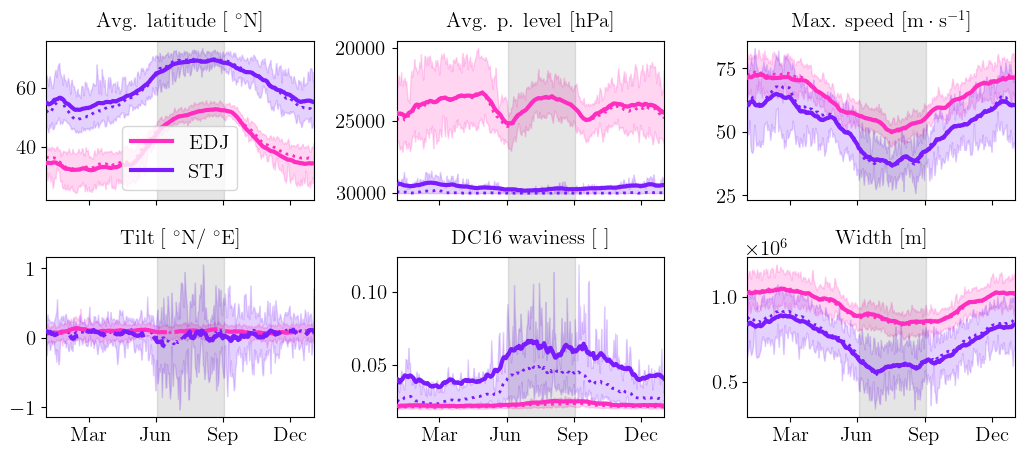

In [ ]:
data_vars = [
    "mean_lat",
    "mean_lev",
    "s_star",
    "tilt",
    "wavinessDC16",
    "width",
]
_ = plot_seasonal(
    props_ctrl, data_vars, nrows=2, ncols=3, clear=False, save=False,
)

data_vars = [
    "mean_lat",
    "mean_lev",
    "s_star",
    "tilt",
    "wavinessDC16",
    "width",
]
_ = plot_seasonal(
    props_dobl, data_vars, nrows=2, ncols=3, clear=False, save=False,
)

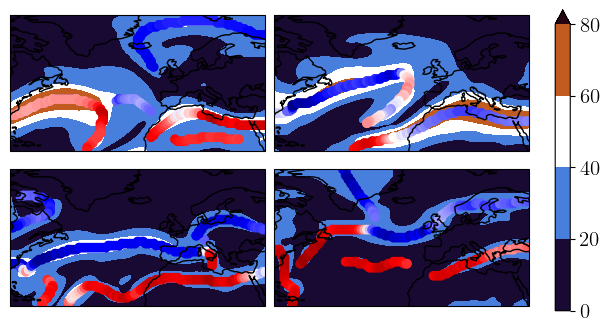

In [28]:
nx, ny = 2, 2
clu = Clusterplot(nx, ny, region=get_region(dh.da))
t = np.sort(np.atleast_1d(np.random.randint(len(dh.da.time), size=nx * ny)))
clu.add_contourf(dh.da["s"][t])
huh = pl.Series(None, dh.da.time[t].values).cast(pl.Datetime("ms")).rename("time").to_frame().join(all_jets_one_df.cast({"time": pl.Datetime("ms")}), on="time").sort("time", "jet ID")
for i, (_, jet_) in enumerate(huh.group_by("time", maintain_order=True)):
    x, y, c = jet_[["lon", "lat", "is_polar"]]
    clu.axes[i].scatter(x - clu.central_longitude, y, c=c, vmin=0, vmax=1, cmap=colormaps.BlWhRe)

In [13]:
jets_means = jets.group_by("time", "jet ID").agg(pl.col(col).mean() for col in ["lon", "lat", "s", "theta", "sigma", "int", "is_polar"])

100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


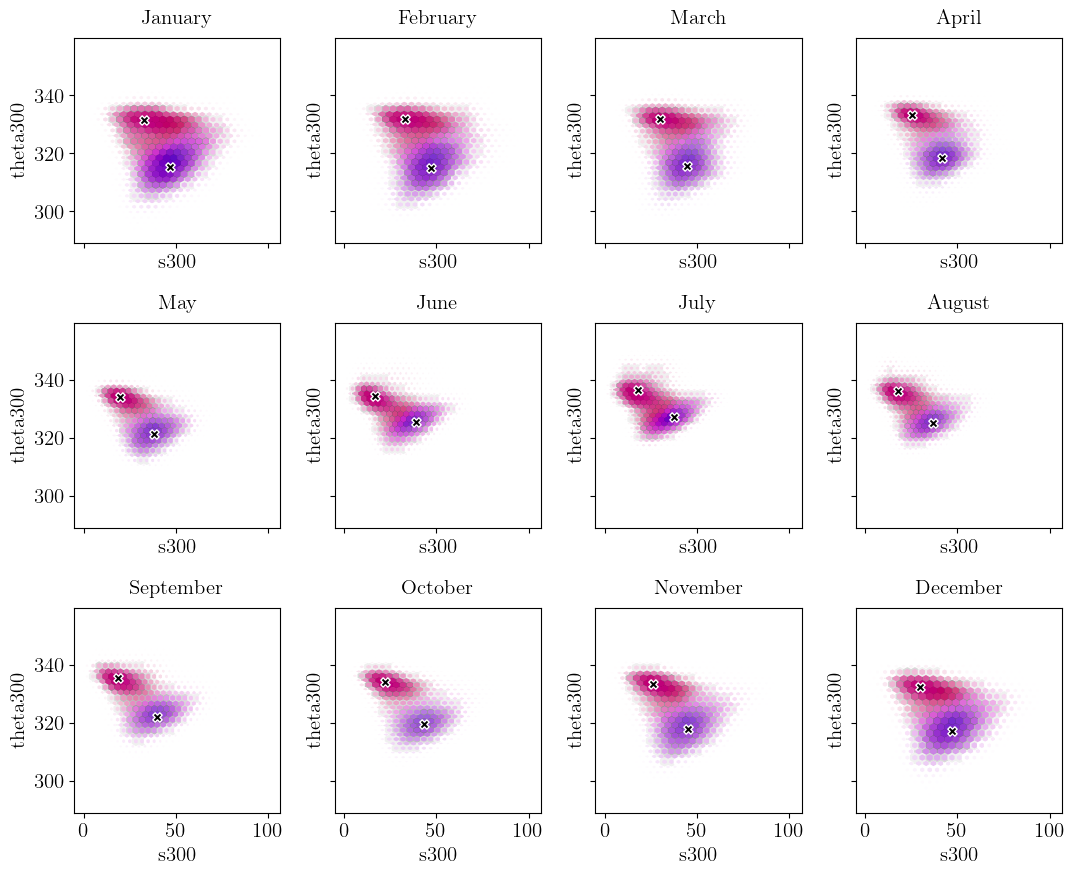

In [4]:
xys = []
all_jets = all_jets_one_df
# .filter(pl.col("int") > 1.1e8)

xys = np.array(xys)
fig, axes = plt.subplots(3, 4, figsize=(11, 9), tight_layout=True, sharex="all", sharey="all")
axes = axes.ravel()
pair = ["s300", "theta300", "is_polar"]
cmap = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])
bins = np.linspace(0, 1, 31)
for month in trange(1, 13):
    ax = axes[month - 1]
    X = extract_features(all_jets, pair, season=month)
    probas = X[pair[2]]
    center_stj = X.filter(pl.col("is_polar") < 0.3).mean()
    center_edj = X.filter(pl.col("is_polar") > 0.7).mean()
    X1D = X["is_polar"]
    
    im1 = ax.hexbin(X[pair[0]], X[pair[1]], cmap=colormaps.gray_r, gridsize=25)
    im2 = ax.hexbin(X[pair[0]], X[pair[1]], C=probas, cmap=colormaps.gray_r, gridsize=25)
    
    plt.draw()
        
    offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
    offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
    mask12 = np.isin(offsets1, offsets2)
    colors = cmap(im2.get_array())
    colors = rgb_to_hsv(colors[:, :3])
    min_s, max_s = 0., 1.0
    min_v, max_v = 0.75, 1.
    scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
    f = lambda x: np.sqrt(x)
    colors[:, 1] = min_s + scaling * (max_s - min_s)
    colors[:, 2] = max_v - scaling * (max_v - min_v)
    colors = hsv_to_rgb(colors)
    im2.set_array(None)
    im2.set_facecolor(colors)
    # im2.set_linewidths(0.2)
    im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
    im2.set_edgecolor(colormaps.greys(scaling))
    im2 = ax.add_collection(im2)
        
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 
        
    ax.set_title(MONTH_NAMES[month - 1])
    ax.scatter(*pl.concat([center_stj, center_edj])[pair[:2]].to_numpy().T, facecolor="black", edgecolor="white", marker="X", linewidths=1, s=45)
    # iax = ax.inset_axes([0.65, 0.2, 0.4, 0.5])
    # X1D = np.clip(X1D, 0, 1)
    # iax.hist(X1D, bins=bins, alpha=0.5, color="black")
    # iax.hist(X1D[probas > 0.5], bins=bins, alpha=0.5, color=COLORS[1])
    # iax.hist(X1D[probas < 0.5], bins=bins, alpha=0.5, color=COLORS[2])
    # iax.set_xticks([0, 0.5, 1])
    # iax.set_yticks([])
    # iax.spines[["left", "right", "top"]].set_visible(False)
    # plt.draw()
# fig.savefig(f"{FIGURES}/jet_detection_demo/gmix_demo")

## next section